# Active Classification #

In the previous notebook an agent tried to maximize its reward by discovering the arms that were more beneficial. We now assume that each arm represents a classification task. Thus instead of making the reward dependent on a fixed distribution, obtaining a reward will depend on whether or not the agent is able to classify correctly an observed stimuli. Accordingly as in the previous notebook the task will return a reward with probability $p$, only that in this case $p$ is the probability that the agent will classify the stimulus correctly.

For each of the tasks there are two types of stimuli that can be presented to the agent. Each class is described by a Gaussian distribution from which the stimuli are sampled. The plots below show four different tasks, with blue and red representing the two different family of stimuli that the agent may observe when selecting that task.

In [27]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.stats import multivariate_normal
from matplotlib.ticker import MaxNLocator
from collections import deque

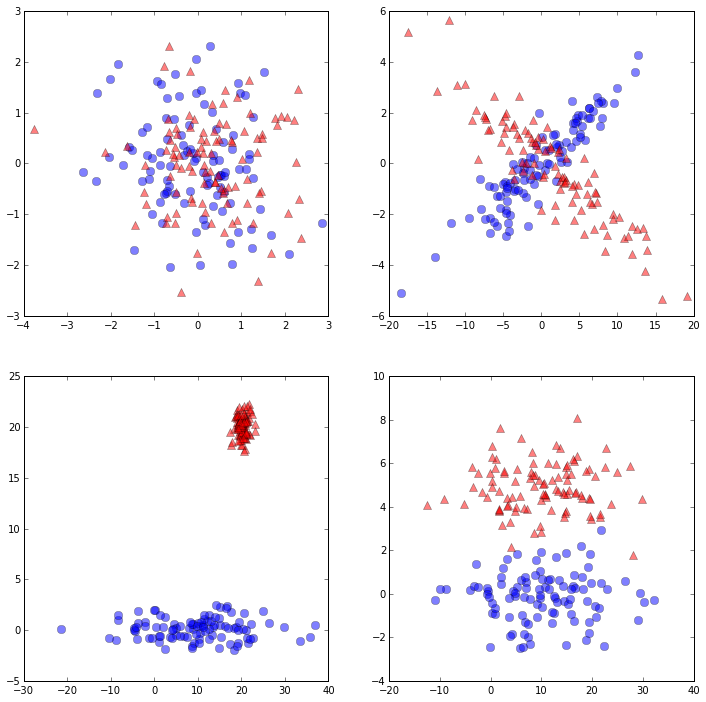

In [28]:
f, axarr = plt.subplots(2, 2, figsize=(12,12))
mu1 = [[0,0], [10,0], [0,0], [10,0]]
mu2 = [[0,0], [20,20], [0,0], [10,5]]
cov1 = [ [[1,0],[0,1]], [[100,0],[0,1]], [[40,10],[10,3]], [[100,0],[0,1]] ]
cov2 = [ [[1,0],[0,1]], [[1,0],[0,1]], [[40,-10],[-10,3]], [[100,0],[0,1]] ]

mu1 = [[0,0], [0,0], [10,0], [10,0]]
mu2 = [[0,0], [0,0], [20,20], [10,5]]
cov1 = [ [[1,0],[0,1]], [[40,10],[10,3]], [[100,0],[0,1]], [[100,0],[0,1]] ]
cov2 = [ [[1,0],[0,1]], [[40,-10],[-10,3]], [[1,0],[0,1]], [[100,0],[0,1]] ]
coord = [ (0,0),(0,1),(1,0),(1,1) ]

for t in range(4):
    class1 = np.random.multivariate_normal(mu1[t], cov1[t], 100).T
    class2 = np.random.multivariate_normal(mu2[t], cov2[t], 100).T
    axarr[coord[t]].plot(class1[0,:], class1[1,:], 'o', markersize=8, color='blue', alpha=0.5, label='class1')
    axarr[coord[t]].plot(class2[0,:], class2[1,:], '^', markersize=8, alpha=0.5, color='red', label='class2')


In [29]:
# Parameters
TASKS = 4 # Number of tasks
SLIDING_WINDOW = 5 # Controls the number of past observations to use
TYPE_AVERAGE = 'exponential' # 'total', 'movAverage' or 'exponential'

In [35]:
# For plotting the evolution of the accumulated rewards
def plotRew(rew, std, steps):
    ax = plt.figure(figsize=(12,9)).gca()
    labels = ['Random','Greedy','$\epsilon$-greedy','TS','ETS','UCB']
    colors = ['blue','red','black','orange','green','brown']
    for r in range(len(rew)):
        ax.plot(rew[r], '-', markersize=8, color=colors[r], alpha=0.5, label=labels[r], linewidth=2.5)
        plt.fill_between(range(len(rew[r])), rew[r]-std[r], rew[r]+std[r], facecolor=colors[r], alpha=0.15)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('Cumulative reward')
    plt.xlabel('Time steps')
    plt.xlim(0, steps-1)
    plt.show()

def initPriors():
    classes = 2
    # Initalize observations for all p(y) with ones so initial p(y)'s = 0.5
    priors = np.ones((TASKS,classes))
    return priors

def initParameters():
    # Initialize parameters needed for likelihoods p(x|y) with mu=[0,..0] cov=identity matrix
    classes = 2
    mu = [[0]*classes for i in range(TASKS)] 
    cov = [[0]*classes for i in range(TASKS)] 
    for task in range(TASKS):
        for cl in range(classes):
            # Prior gaussian mu and covariance
            mu[task][cl] = np.zeros((classes)) #np.array([0,0])
            cov[task][cl] = np.eye(classes) #np.array([[1,0],[0,1]])
            np.fill_diagonal(cov[task][cl], 100)

    return [mu, cov]

def random(counts):
    # Get number of bandits
    numBandits = counts.shape[0]
    return np.random.randint(0,numBandits)

def eGreedy(counts, epsilon=0.1):
    # Get number of bandits
    numBandits = counts.shape[0]
    # Select random choice
    if np.random.random() < epsilon:
        action = np.random.randint(0, numBandits)
    # Or act greedily
    else:
        action = np.argmax(counts[:,2])
    return action

def UCB1(counts, step):
    # Get number of bandits
    numBandits = counts.shape[0]
    # Tunable hyperparameter
    c = 1
    # Store upper confidence bounds
    ucbs = []
    for i in range(numBandits):
        # Get number of times the bandit has been selected (at least once since they've been initialized)
        T = np.sum(counts[i,[0,1]])
        # Get mean(t-1) success for this arm (#success / #times arm has been played)
        mu = counts[i,0] / T
        # Calculate UCB
        # UCB_i(t) = mu_i(t-1) + c * sqrt[2 log t / T_i(t-1)]
        ucb = mu + (c * np.sqrt( (2*np.log(step+1)) / T ))
        ucbs.append(ucb)
    action = np.argmax(ucbs)
    return action

def thompsonSampling(counts, epsilon=0):
    # Get number of bandits
    numBandits = counts.shape[0]
    # The prior is given by a beta distribution, so define prior on alpha and beta (i.e. Beta(a,B))
    # The bandits were initialized for now assuming the prior parameters are the same for all bandits
    alpha = 1
    beta = 1
    samples = []
    
    # Epsilon TS
    # Select random choice
    if np.random.random() < epsilon:
        action = np.random.randint(0, numBandits)
    # Or perform TS as usual
    else:
        for i in range(numBandits):
            # Since it is conjugate we can just get the posterior with the counts and plug it into the distribution
            # Sample from the posterior p(R|History)
            posterior = np.random.beta(counts[i][0] + alpha, counts[i][1] + beta)
            #posterior = np.random.beta(counts[i][0], counts[i][1])
            samples.append(posterior)

        action = np.argmax(samples)
    return action

def selectAction(counts, strategy, step):
    if strategy == 'random':
        action = random(counts)
    elif strategy == 'greedy':
        action = eGreedy(counts, epsilon=0)
    elif strategy == 'eGreedy':
        action = eGreedy(counts)
    elif strategy == 'ucb':
        action = UCB1(counts,step)
    elif strategy == 'thompson':
        action = thompsonSampling(counts)
    elif strategy == 'eThompson':
        action = thompsonSampling(counts, epsilon=0.1)
    return action

# Once the agent has selected a task, this function is called to sample a data point from one of the two distributions
# that are available for that task
def getSample(action):
    mu1 = [[0,0], [0,0], [10,0], [10,0]]
    mu2 = [[0,0], [0,0], [20,20], [10,5]]
    cov1 = [ [[1,0],[0,1]], [[40,10],[10,3]], [[100,0],[0,1]], [[100,0],[0,1]] ]
    cov2 = [ [[1,0],[0,1]], [[40,-10],[-10,3]], [[1,0],[0,1]], [[100,0],[0,1]] ]
    if np.random.random() > 0.5:
        mu = mu1[action]
        cov = cov1[action]
        category = 0
    else:
        mu = mu2[action]
        cov = cov2[action]
        category = 1
    sample = np.random.multivariate_normal(mu, cov)
    return sample, category

### Computing the posterior ###

Once the agent selects one of the tasks, a stimuli is presented to it. The agent receives a reward $r_t=1$ if it predicts correctly the class and $r_t=0$ if it does not. In order to predict the class, the agent relies on a very simple classifier that we will use to generate a posterior distribution telling us the probability that the stimuli belongs to either of the two classes. We define a random variable $Y=\{blue,red\}$ for indicating the class and $X$ for the properties of the stimulus $[x_1,x_2]$. Then the posterior distribution can be obtained by the application of Bayes rule:

$$
P(Y|X) = \dfrac{P(X|Y)P(Y)}{P(X)}
$$

In this case the likelihoods are obtained by evaluating the stimulus in relation to two Gaussians $\mathcal{N}(\mu_{a,1}, \Sigma_{a,1})$ and $\mathcal{N}(\mu_{a,2}, \Sigma_{a,2})$ corresponding to the two possible classes of task $a$. 

In [31]:
def getPosterior(action, category, X, priors, params):

    mu, cov = params
    # get parameters to sample from the distributions [TASKS][CLASSES]
    mu1 = mu[action][0]
    cov1 = cov[action][0]
    mu2 = mu[action][1]
    cov2 = cov[action][1]

    # Likelihoods
    # p(x=Data|y=Class 1)
    pxgy1 = multivariate_normal.pdf(X, mean=mu1, cov=cov1, allow_singular=True)
    # p(x=Data|y=Class 2)
    pxgy2 = multivariate_normal.pdf(X, mean=mu2, cov=cov2, allow_singular=True)

    # Priors
    # First get how many times this task has been observed in total
    numObs = priors[action][0] + priors[action][1]
    # p(y=Class {1,2}) (Number of times an object of class 1 (or 2) has been observed)
    # [TASKS][CLASSES]
    py1 = priors[action][0]/numObs
    py2 = priors[action][1]/numObs
    # Posterior p(y|x)
    py1gx = pxgy1 * py1 / ( (pxgy1 * py1) + (pxgy2 * py2) )
    py2gx = pxgy2 * py2 / ( (pxgy1 * py1) + (pxgy2 * py2) )

    return [py1gx, py2gx]

### Update Parameters ##

To make our predictions, we have observed that we require having an estimate of $\mathcal{N}(\mu_{a,1}, \Sigma_{a,1})$ and $\mathcal{N}(\mu_{a,2}, \Sigma_{a,2})$ for each task. The agent initially starts the experiment assigning the same parameters $\mu_{a,i},\Sigma_{a,i}$ for all distributions, but it refines them based on the observations and feedback it receives.

In [32]:
def updateObs(action, category, X, priors, params, reward, observations):
    # Update number of times a class of monster has been observed
    # [TASKS][CLASSES]
    priors[action][category] += 1

    # Get total number of observations
    numObs = priors[action][0] + priors[action][1]
    # Retrieve specific mean and covariance matrix to update
    mus, covs = params

    # Append new observations
    observations.append([action, category, X[0], X[1]])
    # Factor out

    data = np.array(observations)
    # Extract observations that correspond to a particular action and category
    data = data[np.where((data[:,0]==action) * (data[:,1]==category))]
    # Get only the datapoint X=(X[0],X[1])=(x,y)
    data = data[:,2:4]
    
    #Extract window
    winData = data[-SLIDING_WINDOW:,:]
    
    # Get new mean
    #newMu = np.mean(data, axis=0)
    newMu = np.mean(winData, axis=0)

    # Update mean
    mus[action][category] = newMu
    # Get new covariance
    #newCov = np.cov(data.T)
    newCov = np.cov(winData.T)

    # If it's the first observation we cannot really get the covariance yet and will just generate a matrix of NaNs
    # So only update the covariance if that's not the case otherwise keep the initial assumptions
    if data.shape[0] > 2:
        if not np.isnan(newCov).any():
            # Update covariance
            covs[action][category] = newCov

    # Pack parameters
    params = [mus, covs]
    return priors, params, observations

### Using the posterior as sampling weights ###

Above we have established how we will be calculating the probabilities of a stimulus belonging to the blue or the red class. An option would be to simply select the one that has higher probabilities, but we want to account for the sense of uncertainty associated to making a decision. For instance it would not be the same for the agent to think a stimulus belongs to the red class with 60% and the blue class with 40% as opposed to 90% and 10%. Therefore we sample: $class_a\sim Bernoulli(p_a)$. This means the agent answers blue class with probability $p_a$ and the red class with probability $q_a$.

In [33]:
def observe(action, priors, params, observations):
    # Sample from the distribution of the task that has been selected
    X, category = getSample(action)
    pyx = getPosterior(action, category, X, priors, params)
    # Sample from posterior to select one of the two options
    prediction = np.random.choice([0,1], p=pyx)
    # Verify if prediction is true or not to pass a reward
    if prediction == category:
        reward = 1
    else:
        reward = 0
    # Update observations according to sampleprio
    priors, params, observations = updateObs(action, category, X, priors, params, reward, observations)
    return reward, priors, params, observations

# Updates probability of success based on either all observations, a simple moving average or an exponential moving average
def updatePSuccess(counts, arm, obsWindow):
    if TYPE_AVERAGE == 'total':
        # Takes total number of successes / total number of times the arm has been selected
        counts[arm, 2] = counts[arm, 0] / np.sum(counts[arm, [0,1]])
    elif TYPE_AVERAGE == 'movAverage':
        # Takes successes in window / size of the window
        counts[arm, 2] = np.sum(np.array(obsWindow[arm])[-SLIDING_WINDOW:]) / len(np.array(obsWindow[arm])[-SLIDING_WINDOW:])
    else:
        # Exponential moving average
        counts[arm, 2] = pd.ewma(np.array(obsWindow[arm]), SLIDING_WINDOW)[-1]
    return counts

def simulate(numBandits, steps, strategy='greedy'):
    # Sliding window
    obsWindow = [deque([0,1]) for _ in range(TASKS)] # Initialized with 1 success (reward 1), 1 failure (reward 0)
    #obsWindow = [deque([1,0]), deque([1,0]), deque([1,0]), deque([1,0])] 
    # Initialize prior probabilities
    priors = initPriors()
    # Get initial means and covariances
    params = initParameters()
    observations = []
    # Save total reward and action selected
    statistics = []
    totalReward = 0
    # Store observations about [successes, failures, prob of success]
    counts = np.ones((numBandits, 3)) #counts = np.zeros((numBandits, 3))
    
    if strategy != 'ucb':
        # Accordingly, set initial probabilities of success with 0.5 for each bandit
        counts[:,2] = 0.5

    # UCB1 requires additional initialization
    if strategy == 'ucb':
        # It needs to play each of the arms once
        for arm in range(numBandits):
            # Execute action and observe reward
            reward, priors, params, observations = observe(arm, priors, params, observations)
            totalReward += reward
            statistics.append([totalReward, arm])
            # Update successes and failures for the bandit [(succ, fail) so 1-reward]
            counts[arm, 1-reward] += 1
            # Update sequence of observations of rewards
            obsWindow[arm].append(reward)
            # Update probability of success
            counts = updatePSuccess(counts, arm, obsWindow)

    # For statistics
    actions = [] # Stores task selected by the strategy at each time step
    probs = np.zeros((numBandits, steps)) # Stores prob.s of success for every task at each time step
    succFail = [] # Stores cumulatives successes and failures
    countSF = 0
    
    # Exploration space dynamics
    acT = np.zeros(TASKS)
    expSpace = []
    
    # Capability to predict (learning progress)
    lpT = np.zeros(TASKS)
    leProg = []
    
    for step in range(steps):

        # Apply policy to get an action
        action = selectAction(counts, strategy, step)
        actions.append(action+1)

        # Execute action and observe reward
        reward, priors, params, observations = observe(action, priors, params, observations)
        totalReward += reward
        statistics.append([totalReward, action])
        # Update successes and failures for the bandit [(succ, fail) so 1-reward]
        counts[action, 1-reward] += 1
        # Update sequence of observations of rewards
        obsWindow[action].append(reward)
        # Store succ/fail
        if reward == 0:
            countSF -= 1
        else:
            countSF += 1
        succFail.append(countSF)
        
        # Update probability of success
        #counts[action, 2] = counts[action, 0] / np.sum(counts[action,[0,1]])
        counts = updatePSuccess(counts, action, obsWindow)
        # Store current p of success
        probs[:, step] = counts[:, 2]

        # Store stats
        # Time windows for action
        acT[action]+=1
        # Time windows for prediction ability
        lpT[action]+=reward
        # Store every 10 steps
        if (step+1) % 10 == 0:
            expSpace.append(acT/10)
            acT[:] = 0
            lpT[:] = 0

    #print("COUNTS ", counts)

    return statistics, actions, probs, succFail, counts, expSpace

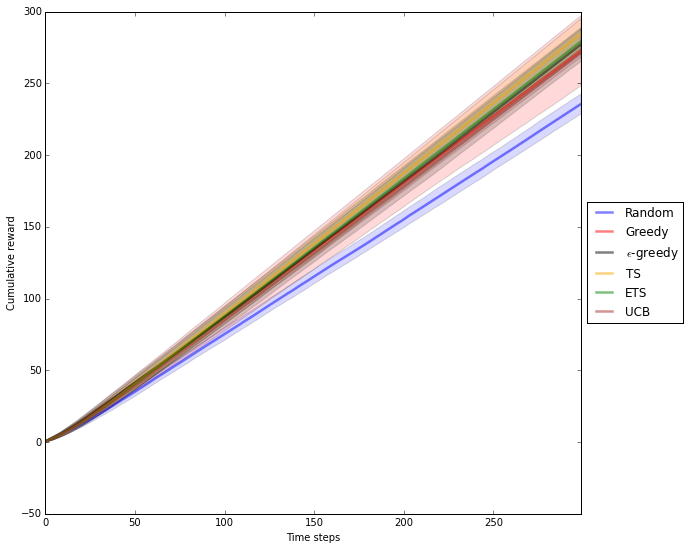

In [37]:
# Number of arms or tasks
numBandits = TASKS

# Store collective history of successes and failures
combSF = []

# For how many steps to run the exercise?
steps = 300

# Store counts and total rewards
cRnd, trRnd = [], []
cGre, trGre = [], []
cEG, trEG = [], []
cTS, trTS = [], []
cETS, trETS = [], []
cUCB, trUCB = [], []

# Store exploration proportions
ExpRnd, ExpGre, ExpEG, ExpTS, ExpETS, ExpUCB = [], [], [], [], [], []
# Store probabilities of success
ProbRnd, ProbGre, ProbEG, ProbTS, ProbETS, ProbUCB = [], [], [], [], [], []
# Store evolution of rewards
rewRnd, rewGre, rewEG, rewTS, rewETS, rewUCB = [], [], [], [], [], []

strategies = ['random','greedy','eGreedy','thompson','eThompson','ucb']
names = ['Rnd', 'Gre', 'EG', 'TS', 'ETS', 'UCB']
plotNames = ['Random', 'Greedy', 'e-Greedy', 'Thompson Sampling', 'e-TS', 'UCB1']
for st in range(len(strategies)):
    
    # How many times to repeat it
    repetitions = 100
    for rep in range(repetitions):
        stats, actions, probs, sf, counts, expSpace = simulate(numBandits, steps, strategy=strategies[st])
        combSF.append(sf)
        # explorationDyn(actions, plotNames[st])
        #probDyn(probs, plotNames[st])
        #succFailDyn(sf, plotNames[st])
        var = ''.join(['c',names[st]])
        vars()[var].append(counts)
        var = ''.join(['tr',names[st]])
        vars()[var].append(stats[-1][0])
        var = ''.join(['Exp',names[st]])
        vars()[var].append(expSpace)
        var = ''.join(['Prob',names[st]])
        vars()[var].append(probs)
        #lpDyn(probs, plotNames[st])
        
        var = ''.join(['rew',names[st]])
        vars()[var].append(np.array(stats)[:,0])

# Store reward means/std devs for plotting
rewMean, rewStd = [], []
names = ['Rnd', 'Gre', 'EG', 'TS', 'ETS', 'UCB']
for i in range(len(names)):
    var = ''.join(['rew',names[i]])
    rewMean.append(np.mean(vars()[var], axis=0))
    rewStd.append(np.std(vars()[var], axis=0))
    
plotRew(rewMean, rewStd, steps)

Above, the plot shows the performance of the different strategies in terms of their cumulative reward regardless of the selected task. The simulation is run for 1000 time steps and averaged over 100 executions. The semi-transparent colors correspond to the standard deviation.